### Adi Pradhan
__Udacity MLND Final Project Nov 2018__

Kaggle competition link: https://www.kaggle.com/c/new-york-city-taxi-fare-prediction

Data cleanup, munging and model training code

In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import feather
import re

### Data Cleanup and Feature Engineering

In [2]:
%%time
import feather
raw_data = feather.read_dataframe('../data/taxi/train.1M.feather')
raw_data = raw_data[:500_000]

CPU times: user 49.5 ms, sys: 9.88 ms, total: 59.4 ms
Wall time: 3.31 s


In [3]:
num_rows = raw_data.shape[0]
train_rows = int(0.8*num_rows)

In [4]:
kaggle = pd.read_csv('../data/taxi/test.csv',parse_dates=['pickup_datetime'])
kaggle = kaggle.drop('key',axis='columns')

In [5]:
raw_data.describe()
raw_data.dtypes

fare_amount                 float64
pickup_datetime      datetime64[ns]
pickup_longitude            float64
pickup_latitude             float64
dropoff_longitude           float64
dropoff_latitude            float64
passenger_count               int64
dtype: object

In [6]:
# drop missing values and negative fares
raw_data = raw_data.dropna(how='any',axis='rows')
raw_data = raw_data[raw_data.fare_amount > 0]

In [7]:
raw_data.fare_amount.describe()

count    499960.000000
mean         11.359244
std           9.915389
min           0.010000
25%           6.000000
50%           8.500000
75%          12.500000
max         500.000000
Name: fare_amount, dtype: float64

In [8]:
per = [0.00001,0.001,0.01,0.03,0.05,0.1,0.9,0.95,0.97,0.99,0.995,0.999,0.9999,0.9999999]
for p in per:
    print(f'The {p*100}% percentile of fare_amount is: {raw_data.fare_amount.quantile(p):.2f}')

The 0.001% percentile of fare_amount is: 1.50
The 0.1% percentile of fare_amount is: 2.50
The 1.0% percentile of fare_amount is: 3.30
The 3.0% percentile of fare_amount is: 3.70
The 5.0% percentile of fare_amount is: 4.10
The 10.0% percentile of fare_amount is: 4.50
The 90.0% percentile of fare_amount is: 20.50
The 95.0% percentile of fare_amount is: 30.50
The 97.0% percentile of fare_amount is: 38.50
The 99.0% percentile of fare_amount is: 52.10
The 99.5% percentile of fare_amount is: 57.33
The 99.9% percentile of fare_amount is: 80.00
The 99.99% percentile of fare_amount is: 160.00
The 99.99999000000001% percentile of fare_amount is: 499.75


In [9]:
#raw_data = raw_data[(raw_data.fare_amount <= 155) & (raw_data.fare_amount > 2.5)]

In [10]:
def add_datepart(df, fldname, drop=True, time=False):
    "Helper function that adds columns relevant to a date."
    fld = df[fldname]
    fld_dtype = fld.dtype
    if isinstance(fld_dtype, pd.core.dtypes.dtypes.DatetimeTZDtype):
        fld_dtype = np.datetime64

    if not np.issubdtype(fld_dtype, np.datetime64):
        df[fldname] = fld = pd.to_datetime(fld, infer_datetime_format=True)
    targ_pre = re.sub('[Dd]ate$', '', fldname)
    attr = ['Year', 'Month', 'Week', 'Day', 'Dayofweek', 'Dayofyear',
            'Is_month_end', 'Is_month_start', 'Is_quarter_end', 'Is_quarter_start', 'Is_year_end', 'Is_year_start']
    if time: attr = attr + ['Hour', 'Minute', 'Second']
    for n in attr: df[targ_pre + n] = getattr(fld.dt, n.lower())
    df[targ_pre + 'Elapsed'] = fld.astype(np.int64) // 10 ** 9
    if drop: df.drop(fldname, axis=1, inplace=True)

In [11]:
add_datepart(raw_data,'pickup_datetime',time=True)

In [12]:
add_datepart(kaggle,'pickup_datetime',time=True)

In [13]:
raw_data.head()

fare_amount  pickup_longitude  pickup_latitude  dropoff_longitude  \
0          4.5        -73.844311        40.721319         -73.841610   
1         16.9        -74.016048        40.711303         -73.979268   
2          5.7        -73.982738        40.761270         -73.991242   
3          7.7        -73.987130        40.733143         -73.991567   
4          5.3        -73.968095        40.768008         -73.956655   

   dropoff_latitude  passenger_count  pickup_datetimeYear  \
0         40.712278                1                 2009   
1         40.782004                1                 2010   
2         40.750562                2                 2011   
3         40.758092                1                 2012   
4         40.783762                1                 2010   

   pickup_datetimeMonth  pickup_datetimeWeek  pickup_datetimeDay  \
0                     6                   25                  15   
1                     1                    1                   5   
2                     8                   33                  18   
3                     4                   16                  21   
4                     3                   10                   9   

            ...            pickup_datetimeIs_month_end  \
0           ...                                  False   
1           ...                                  False   
2           ...                                  False   
3           ...                                  False   
4           ...                                  False   

   pickup_datetimeIs_month_start  pickup_datetimeIs_quarter_end  \
0                          False                          False   
1                          False                          False   
2                          False                          False   
3                          False                          False   
4                          False                          False   

   pickup_datetimeIs_quarter_start  pickup_datetimeIs_year_end  \
0                            False                       False   
1                            False                       False   
2                            False                       False   
3                            False                       False   
4                            False                       False   

   pickup_datetimeIs_year_start  pickup_datetimeHour  pickup_datetimeMinute  \
0                         False                   17                     26   
1                         False                   16                     52   
2                         False                    0                     35   
3                         False                    4                     30   
4                         False                    7                     51   

   pickup_datetimeSecond  pickup_datetimeElapsed  
0                     21              1245086781  
1                     16              1262710336  
2                      0              1313627700  
3                     42              1334982642  
4                      0              1268121060  

[5 rows x 22 columns]

In [14]:
raw_data['abs_diff_lat'] = (raw_data.dropoff_latitude - raw_data.pickup_latitude).abs()
raw_data['abs_diff_lon'] = ( raw_data.dropoff_longitude - raw_data.pickup_longitude).abs()
raw_data['dist_manhattan']= raw_data.abs_diff_lat + raw_data.abs_diff_lon

In [15]:
kaggle['abs_diff_lat'] = (kaggle.dropoff_latitude - kaggle.pickup_latitude).abs()
kaggle['abs_diff_lon'] = ( kaggle.dropoff_longitude - kaggle.pickup_longitude).abs()
kaggle['dist_manhattan']= kaggle.abs_diff_lat + kaggle.abs_diff_lon

In [16]:
# Haversine 

# Radius of the earth in kilometers
R = 6378.137

def haversine_np(lon1, lat1, lon2, lat2):
    """
    Calculate the great circle distance between two points
    on the earth (specified in decimal degrees)

    All args must be of equal length.    
    
    source: https://stackoverflow.com/a/29546836

    """
    # Convert latitude and longitude to radians
    lon1, lat1, lon2, lat2 = map(np.radians, [lon1, lat1, lon2, lat2])

    # Find the differences
    dlon = lon2 - lon1
    dlat = lat2 - lat1

    # Apply the formula 
    a = np.sin(dlat/2.0)**2 + np.cos(lat1) * np.cos(lat2) * np.sin(dlon/2.0)**2
    # Calculate the angle (in radians)
    c = 2 * np.arcsin(np.sqrt(a))
    # Convert to kilometers
    km = R * c
    miles = km * 0.621371
    return miles

In [17]:
raw_data['haversine'] = haversine_np(raw_data['pickup_longitude'], raw_data['pickup_latitude'],
                         raw_data['dropoff_longitude'], raw_data['dropoff_latitude'])
raw_data['num_fifths'] = round(raw_data['haversine']/0.2)

In [18]:
raw_data['weekend'] = raw_data.pickup_datetimeDayofweek.apply(lambda day: 1 if (day == 5) or (day == 6) else 0)

In [ ]:
night_mask = (raw_data.pickup_datetimeHour >= 20) | (raw_data.pickup_datetimeHour <= 6)
not_night_mask = (raw_data.pickup_datetimeHour < 20) & (raw_data.pickup_datetimeHour > 6)
raw_data.loc[night_mask,'night_surcharge'] = 1
raw_data.loc[not_night_mask,'night_surcharge'] = 0

In [ ]:
weekday_mask = ((raw_data.weekend ==0) & (raw_data.pickup_datetimeHour >= 16) & (raw_data.pickup_datetimeHour <=20))
not_weekday_mask = ((raw_data.weekend !=0) & (raw_data.pickup_datetimeHour < 16) & (raw_data.pickup_datetimeHour >20))
raw_data.loc[weekday_mask,'weekday_surcharge'] = 1
raw_data.loc[not_weekday_mask,'weekday_surcharge'] = 0

In [ ]:
kaggle['haversine'] = haversine_np(kaggle['pickup_longitude'], kaggle['pickup_latitude'],
                         kaggle['dropoff_longitude'], kaggle['dropoff_latitude'])
kaggle['num_fifths'] = round(kaggle['haversine']/0.2)

kaggle['weekend'] = kaggle.pickup_datetimeDayofweek.apply(lambda day: 1 if (day == 5) or (day == 6) else 0)

In [ ]:
per = [0.00001,0.001,0.01,0.1,0.9,0.95,0.99,0.995,0.9975,0.999]
for p in per:
    print(f'The {p*100}% percentile of distance is {raw_data.haversine.quantile(p):.2f} miles')

The 0.001% percentile of distance is 0.00 miles
The 0.1% percentile of distance is 0.00 miles
The 1.0% percentile of distance is 0.00 miles
The 10.0% percentile of distance is 0.45 miles
The 90.0% percentile of distance is 4.38 miles
The 95.0% percentile of distance is 6.31 miles
The 99.0% percentile of distance is 12.85 miles
The 99.5% percentile of distance is 13.62 miles
The 99.75% percentile of distance is 19.79 miles
The 99.9% percentile of distance is 5390.41 miles


In [ ]:
raw_data = raw_data[raw_data.haversine <20]

In [ ]:
jfk_lat = 40.639722
jfk_lon = -1*73.77889
laguardia_lat = 40.77725
laguardia_lon = -1*73.87261
newark_lat = 40.6925
newark_lon = -1*74.1768611

precision=2
#JFK
mask_from_jfk = (round(raw_data['pickup_latitude'],precision) == round(jfk_lat,precision)) & (round(raw_data['pickup_longitude'],precision) == round(jfk_lon,precision))
raw_data.loc[mask_from_jfk,'from_jfk'] = 1

mask_to_jfk = (round(raw_data['dropoff_latitude'],precision) == round(jfk_lat,precision)) & (round(raw_data['dropoff_longitude'],precision)== round(jfk_lon,precision))
raw_data.loc[mask_to_jfk,'to_jfk'] = 1

#LaGuardia
mask_from_laguardia = (round(raw_data['pickup_latitude'],precision) == round(laguardia_lat,precision)) & (round(raw_data['pickup_longitude'],precision) == round(laguardia_lon,precision))
raw_data.loc[mask_from_laguardia,'from_laguardia'] = 1

mask_to_laguardia  = (round(raw_data['dropoff_latitude'],precision) == round(laguardia_lat,precision)) & (round(raw_data['dropoff_longitude'],precision) == round(laguardia_lon,precision))
raw_data.loc[mask_to_laguardia,'to_laguardia'] = 1

#Newark
mask_from_newark = (round(raw_data['pickup_latitude'],precision) == round(newark_lat,precision)) & (round(raw_data['pickup_longitude'],precision) == round(newark_lon,precision))
raw_data.loc[mask_from_newark,'from_newark'] = 1

mask_to_newark = (round(raw_data['dropoff_latitude'],precision) == round(newark_lat,precision)) & (round(raw_data['dropoff_longitude'],precision) == round(newark_lon,precision))
raw_data.loc[mask_to_newark,'to_newark'] = 1

In [ ]:
raw_data.fillna(0,inplace=True)

In [ ]:
train_df = raw_data[:train_rows]
test_df = raw_data[train_rows:]

In [ ]:
train_df.fare_amount.mean()

11.334966149999998

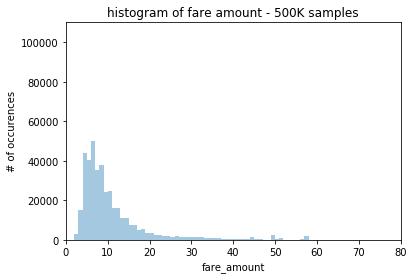

In [ ]:
fig, ax = plt.subplots()
ax.axis([0,80,0,110_000])
ax.set_title('histogram of fare amount - 500K samples')
ax.set_ylabel('# of occurences')
sns.distplot(train_df.fare_amount,ax=ax,kde=False,bins=500)

In [ ]:
raw_data.fare_amount.std()

9.752766393559364

In [ ]:
raw_data.fare_amount.median()

8.5

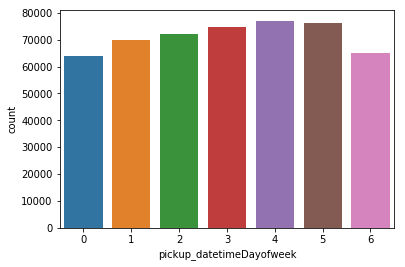

In [ ]:
sns.countplot(x=raw_data.pickup_datetimeDayofweek)

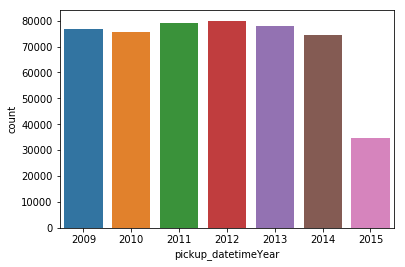

In [ ]:
sns.countplot(x=raw_data.pickup_datetimeYear)

In [ ]:
c = raw_data.corr()

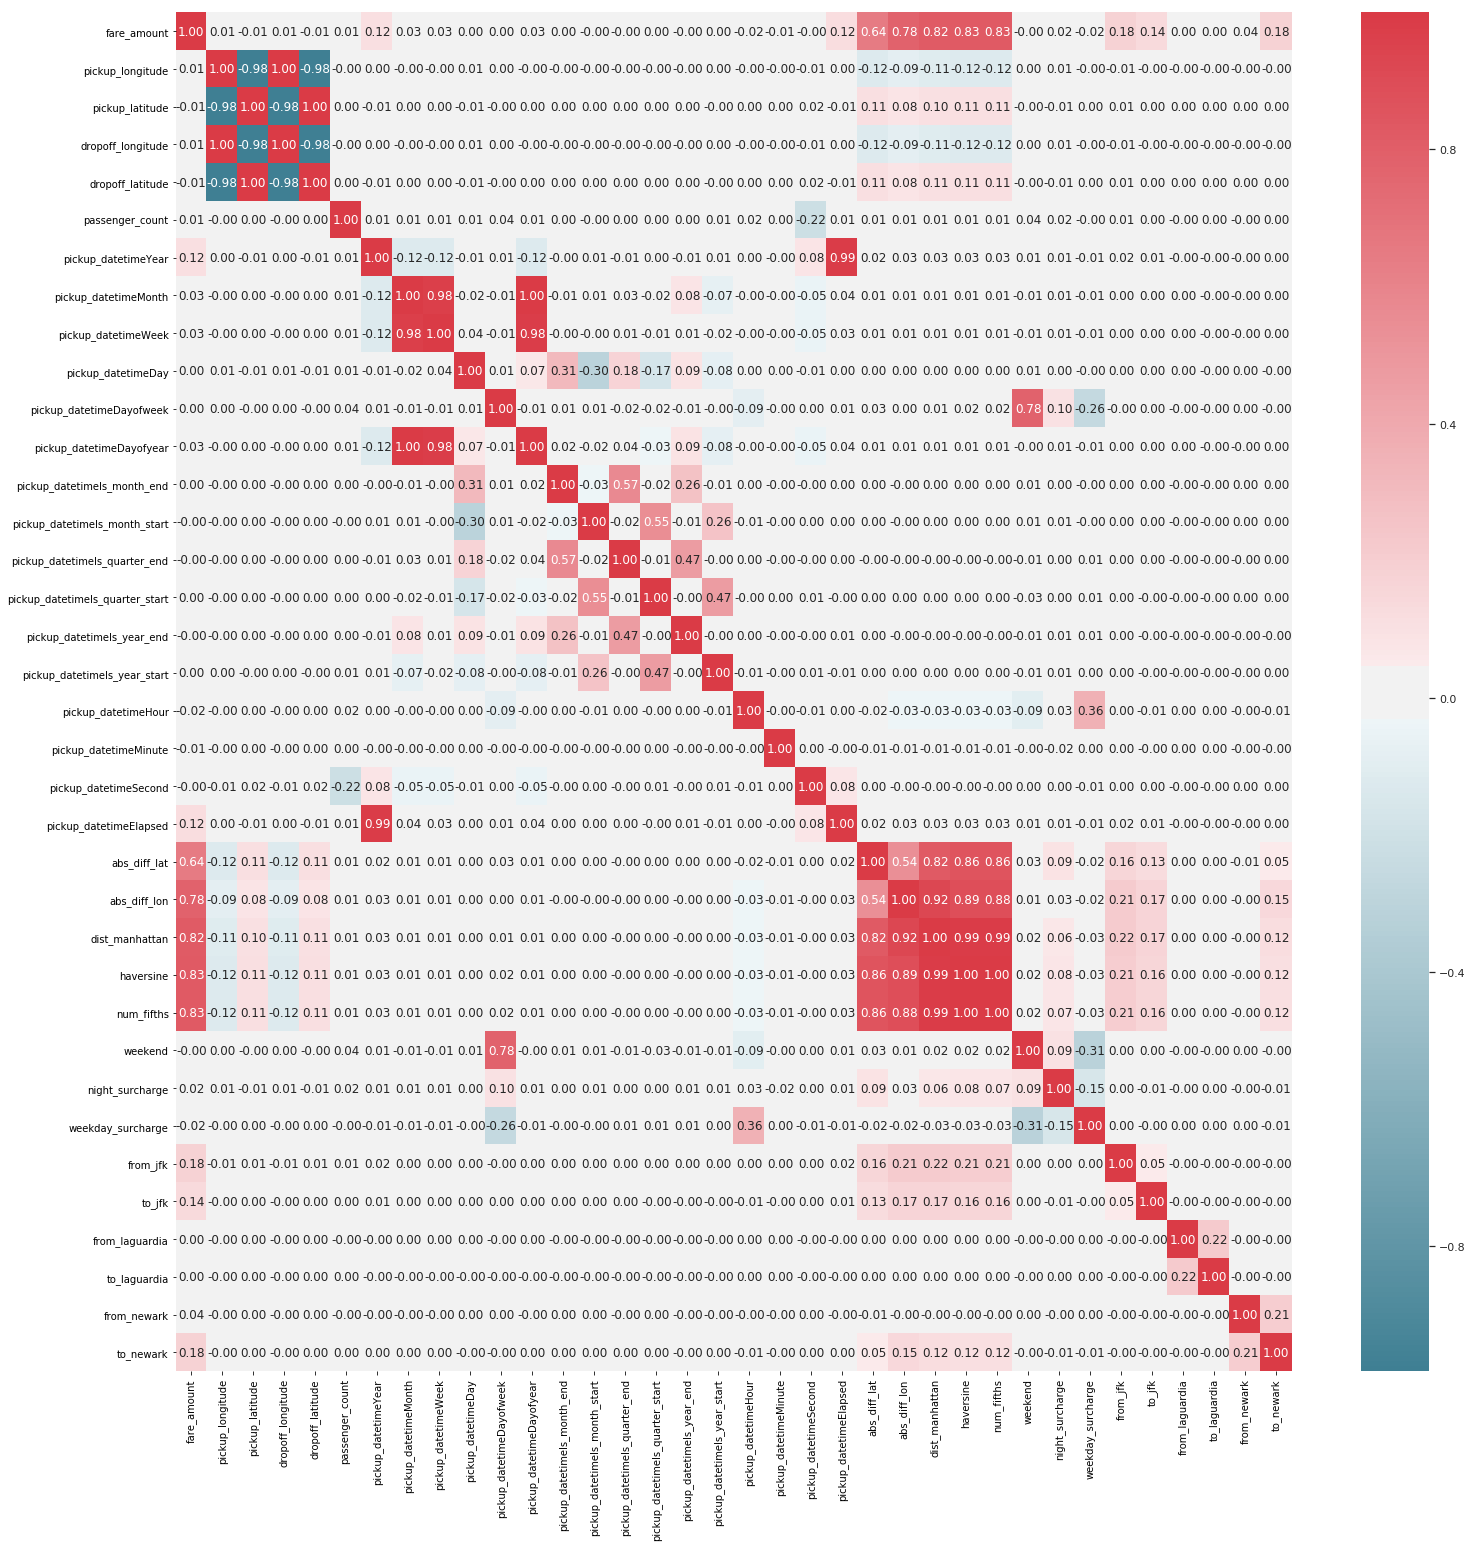

In [ ]:
fig,ax = plt.subplots(figsize=(25,25))
sns.set(style='white')
cmap = sns.diverging_palette(220, 10, as_cmap=True)
sns.heatmap(c,cmap=cmap,ax=ax,annot=True,fmt='.2f',)

In [ ]:
y_train = train_df.fare_amount
X_train = train_df.drop('fare_amount',axis='columns')

y_test = test_df.fare_amount
X_test = test_df.drop('fare_amount',axis='columns')

In [ ]:
from sklearn.metrics import mean_squared_error

def rmse_error(y_true,y_pred):
    return np.sqrt(mean_squared_error(y_true, y_pred))

### Linear Regression baseline

In [ ]:
from sklearn.linear_model import LinearRegression
reg = LinearRegression()
X_train_linreg = X_train.dist_manhattan.values.reshape(-1,1)
X_test_linreg = X_test.dist_manhattan.values.reshape(-1,1)
reg.fit(X=X_train_linreg,y=y_train)
y_hat = reg.predict(X_test_linreg)
error_linreg = rmse_error(y_test,y_hat)
print(f'Error from baseline model: linear regression =  {error_linreg:.2f}')

Error from baseline model: linear regression =  5.52


### Random Forest Model

In [ ]:
from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import RandomForestRegressor
from sklearn.pipeline import make_pipeline

reg = make_pipeline(StandardScaler(),
                    RandomForestRegressor(n_estimators=100,max_depth=30,n_jobs=-1,min_samples_leaf=1,verbose=1))
reg.fit(X_train,y_train)
y_hat_rf = reg.predict(X_test)
error_rf = rmse_error(y_test,y_hat_rf)
print(error_rf)

/home/ec2-user/SageMaker/envs/fastai/lib/python3.6/site-packages/sklearn/preprocessing/data.py:617: DataConversionWarning: Data with input dtype bool, int64, float64 were all converted to float64 by StandardScaler.
  return self.partial_fit(X, y)
/home/ec2-user/SageMaker/envs/fastai/lib/python3.6/site-packages/sklearn/base.py:465: DataConversionWarning: Data with input dtype bool, int64, float64 were all converted to float64 by StandardScaler.
  return self.fit(X, y, **fit_params).transform(X)
[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  42 tasks      | elapsed:  2.6min
[Parallel(n_jobs=-1)]: Done 100 out of 100 | elapsed:  5.9min finished
/home/ec2-user/SageMaker/envs/fastai/lib/python3.6/site-packages/sklearn/pipeline.py:331: DataConversionWarning: Data with input dtype bool, int64, float64 were all converted to float64 by StandardScaler.
  Xt = transform.transform(Xt)
[Parallel(n_jobs=4)]: Using backend ThreadingBacken

4.404916618257868


[Parallel(n_jobs=4)]: Done 100 out of 100 | elapsed:    1.6s finished


### xgboost

In [ ]:
import xgboost as xgb
dtrain = xgb.DMatrix(X_train,y_train)
dtest = xgb.DMatrix(X_test)

In [ ]:
#set parameters for xgboost
params = {'max_depth':5,
          'eta':1,
          'silent':1,
          'objective':'reg:linear',
          'eval_metric':'rmse',
          'learning_rate':0.05
         }
num_rounds = 100

In [ ]:
xgb_model = xgb.train(params,dtrain,num_rounds)

In [ ]:
y_hat_xgb = xgb_model.predict(dtest)
rmse_xgb = rmse_error(y_test,y_hat_xgb)
print(rmse_xgb)

4.318229274873874


### Deep Neural Network

In [ ]:
from keras.models import Sequential, load_model
from keras.layers import Dense, BatchNormalization, Dropout
from keras.optimizers import Adam
from keras.callbacks import EarlyStopping, ModelCheckpoint

Using TensorFlow backend.


In [ ]:
early_stop = EarlyStopping(monitor='val_loss',patience=5)
model_checkpoint = ModelCheckpoint('keras.model.best', monitor='val_loss', verbose=0, save_best_only=True, save_weights_only=False, mode='auto', period=1)

In [ ]:
model = Sequential()
model.add(Dense(512, activation='relu', input_dim=X_train.shape[1]))
model.add(BatchNormalization())
model.add(Dropout(0.5))
model.add(Dense(256, activation='relu'))
model.add(BatchNormalization())
model.add(Dropout(0.5))
model.add(Dense(1))

adam = Adam(lr=0.001)
model.compile(loss='mse', optimizer=adam, metrics=['mse'])

In [ ]:
s = StandardScaler()
X_train = s.fit_transform(X_train)

/home/ec2-user/SageMaker/envs/fastai/lib/python3.6/site-packages/sklearn/preprocessing/data.py:617: DataConversionWarning: Data with input dtype bool, int64, float64 were all converted to float64 by StandardScaler.
  return self.partial_fit(X, y)
/home/ec2-user/SageMaker/envs/fastai/lib/python3.6/site-packages/sklearn/base.py:462: DataConversionWarning: Data with input dtype bool, int64, float64 were all converted to float64 by StandardScaler.
  return self.fit(X, **fit_params).transform(X)


In [ ]:
hist = model.fit(X_train,y_train,batch_size=2048,epochs=100,verbose=True,
                 validation_split=0.1,callbacks=[early_stop])

Train on 360000 samples, validate on 40000 samples
Epoch 1/100
360000/360000 [==============================] - 17s 46us/step - loss: 107.6212 - mean_squared_error: 107.6212 - val_loss: 34.4670 - val_mean_squared_error: 34.4670
Epoch 2/100
360000/360000 [==============================] - 13s 36us/step - loss: 35.5729 - mean_squared_error: 35.5729 - val_loss: 25.6263 - val_mean_squared_error: 25.6263
Epoch 3/100
360000/360000 [==============================] - 13s 36us/step - loss: 31.6633 - mean_squared_error: 31.6633 - val_loss: 25.0124 - val_mean_squared_error: 25.0124
Epoch 4/100
360000/360000 [==============================] - 13s 36us/step - loss: 29.6077 - mean_squared_error: 29.6077 - val_loss: 24.8622 - val_mean_squared_error: 24.8622
Epoch 5/100
360000/360000 [==============================] - 13s 36us/step - loss: 28.6820 - mean_squared_error: 28.6820 - val_loss: 24.6889 - val_mean_squared_error: 24.6889
Epoch 6/100
360000/360000 [==============================] - 13s 36us/st

In [ ]:
model = load_model('keras.model.best')

In [ ]:
y_hat_nn = model.predict(s.fit_transform(X_test))
rmse_error(y_test,y_hat_nn)

## Ensemble

In [ ]:
y_hat_nn = y_hat_nn.reshape(1,-1)
y_hat_nn = y_hat_nn[0]

In [ ]:
y_hat = pd.DataFrame({
    'rf':y_hat_rf,
    'xgb':y_hat_xgb,
    'dnn':y_hat_nn
})

In [ ]:
y_hat_ensemble = np.mean(y_hat,axis='columns')
rmse_ensemble = rmse_error(y_test,y_hat_ensemble)
print(rmse_ensemble)

In [ ]:
y_hat_ensemble.describe()

In [ ]:
y_test.describe()